# Advanced Cycling FIT File Analysis
This notebook provides a clean, structured workflow for advanced cycling analysis aligned with current scientific best practices.
Sections:
1. Import Libraries
2. Parse FIT File
3. Clean and Smooth Data
4. Session Summary Metrics
5. Core Analysis (Zones, Plots)
6. Lap Analysis
7. Advanced Analysis (CP Estimation, W' Bal, Torque, Lactate)


## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import fitparse

## 2. Parse FIT File

In [2]:
fitfile = fitparse.FitFile('/Users/tajkrieger/Downloads/Truckee_Gravel_6th.fit')  # Replace with your file
records = [{field.name: field.value for field in record} for record in fitfile.get_messages('record')]
laps = [{field.name: field.value for field in lap} for lap in fitfile.get_messages('lap')]
df = pd.DataFrame(records)
print(df.shape)
df.head()

(18927, 20)


,cadence,calories,distance,enhanced_speed,gps_accuracy,position_lat,position_long,power,speed,timestamp,heart_rate,altitude,ascent,battery_soc,descent,enhanced_altitude,grade,temperature,left_pedal_smoothness,left_torque_effectiveness
0,0,0,0.0,0.0,8,469209998,-1433510889,0,0.0,2025-06-28 15:00:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0.0,0.0,8,469209959,-1433510863,0,0.0,2025-06-28 15:00:25,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,0,0.0,0.0,8,469209920,-1433510837,8,0.0,2025-06-28 15:00:26,94.0,1822.6,0.0,83.0,0.0,1822.6,0.0,NaN,NaN,NaN
3,7,0,0.0,0.0,8,469209881,-1433510811,27,0.0,2025-06-28 15:00:27,95.0,1827.8,0.0,NaN,0.0,1827.8,0.0,NaN,NaN,NaN
4,21,0,0.0,0.0,8,469209839,-1433510709,35,0.0,2025-06-28 15:00:28,98.0,1831.8,0.0,NaN,0.0,1831.8,0.0,NaN,NaN,NaN


## 3. Clean and Smooth Data

In [3]:
if 'speed' in df.columns:
    df['speed_kmh'] = df['speed'] * 3.6
if 'distance' in df.columns:
    df['distance_km'] = df['distance'] / 1000
for col in ['power', 'cadence', 'heart_rate', 'speed_kmh']:
    if col in df.columns:
        df[col] = df[col].interpolate(limit_direction='both')
smoothing_windows = {'power':30, 'heart_rate':30, 'cadence':30, 'speed_kmh':10}
for col in smoothing_windows:
    if col in df.columns:
        df[col+'_smoothed'] = df[col].rolling(window=smoothing_windows[col], min_periods=1, center=True).mean()
print('Data cleaned and smoothed.')

Data cleaned and smoothed.


## 4. Session Summary Metrics

In [4]:
ftp = 250  # Adjust per athlete
np_calc = (df['power'].rolling(window=30, min_periods=1).mean() ** 4).mean() ** 0.25
avg_power = df['power'].mean()
IF = np_calc / ftp
duration_hr = (df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]).total_seconds() / 3600
TSS = (duration_hr * np_calc * IF) / ftp * 100
VI = np_calc / avg_power
print(f'Normalized Power: {np_calc:.0f} W, IF: {IF:.2f}, TSS: {TSS:.0f}, VI: {VI:.2f}')

Normalized Power: 223 W, IF: 0.89, TSS: 418, VI: 1.15


## 5. Core Analysis: Zones and Plots

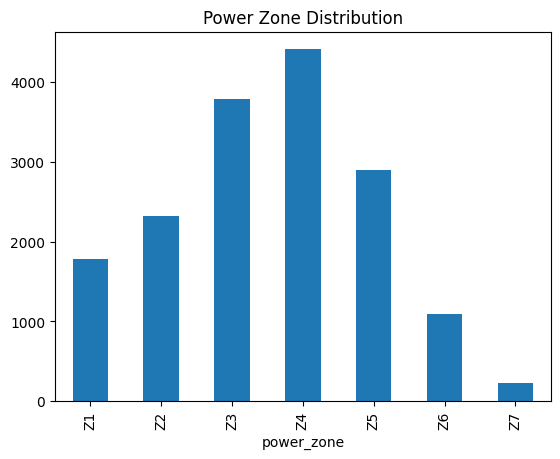

In [5]:
# Power Zone Distribution
if 'power' in df.columns:
    df['pct_ftp'] = (df['power'] / ftp) * 100
    bins = [0, 55, 75, 90, 105, 120, 150, np.inf]
    labels = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7']
    df['power_zone'] = pd.cut(df['pct_ftp'], bins=bins, labels=labels)
    df['power_zone'].value_counts().sort_index().plot(kind='bar', title='Power Zone Distribution')
    plt.show()

## 6. Lap Analysis

In [6]:
if laps:
    lap_df = pd.DataFrame(laps)
    display(lap_df)
else:
    print('No lap data available.')

,avg_altitude,avg_cadence,avg_grade,avg_heart_rate,avg_power,avg_speed,avg_temperature,enhanced_avg_altitude,enhanced_avg_speed,enhanced_max_altitude,...,time_in_hr_zone,time_in_power_zone,timestamp,total_ascent,total_calories,total_descent,total_distance,total_elapsed_time,total_timer_time,total_work
0,2076.8,86,0.94,159,195,8.678,23,2076.8,8.678,2490.4,...,"(60.1, 1875.024, 6393.441, 10499.21, 97.593)","(4661.313, 3457.792, 4840.246, 4020.756, 1422....",2025-06-28 20:15:53,10551,3699,10262,164256.63,18929.0,18927.0,3698908


## 7. Advanced Analysis

### 7.1 Critical Power (CP) Estimation

In [7]:
def cp_model(t, CP, W_prime):
    return CP + (W_prime / t)
durations = np.array([5, 15, 30, 60, 120, 300, 600])
mmp = [df['power'].rolling(window=d, min_periods=1).mean().max() for d in durations]
popt, _ = curve_fit(cp_model, durations, mmp, bounds=(0, [600, 100000]))
cp_est, w_prime_est = popt
print(f'Estimated CP: {cp_est:.0f} W, W\': {w_prime_est:.0f} J')

Estimated CP: 335 W, W': 1543 J


### 7.2 W' Balance Tracking

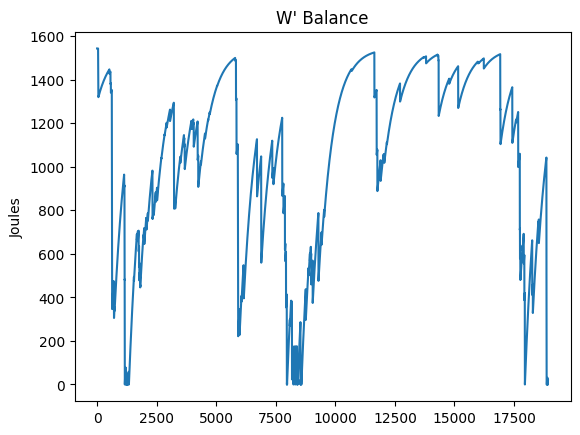

In [8]:
tau = 546
w_bal = []
current_w_prime = w_prime_est
timestamps = pd.to_datetime(df['timestamp'])
time_diffs = timestamps.diff().dt.total_seconds().fillna(1).clip(lower=0.01)
for idx, row in df.iterrows():
    power = row['power']
    dt = time_diffs.iloc[idx]
    if power > cp_est:
        current_w_prime -= (power - cp_est) * dt
    else:
        recovery = (w_prime_est - current_w_prime) * (1 - np.exp(-dt / tau))
        current_w_prime += recovery
    current_w_prime = max(0, min(current_w_prime, w_prime_est))
    w_bal.append(current_w_prime)
df['w_prime_bal'] = w_bal
df['w_prime_bal'].plot(title="W' Balance")
plt.ylabel('Joules')
plt.show()

### 7.3 Torque Analysis

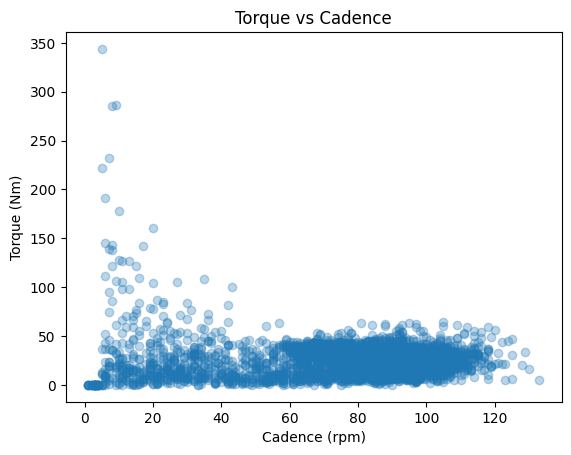

In [9]:
if 'power' in df.columns and 'cadence' in df.columns:
    df['torque'] = (df['power'] * 60) / (2 * np.pi * df['cadence'].replace(0, np.nan))
    plt.scatter(df['cadence'], df['torque'], alpha=0.3)
    plt.title('Torque vs Cadence')
    plt.xlabel('Cadence (rpm)')
    plt.ylabel('Torque (Nm)')
    plt.show()

### 7.4 Lactate Estimation Modeling

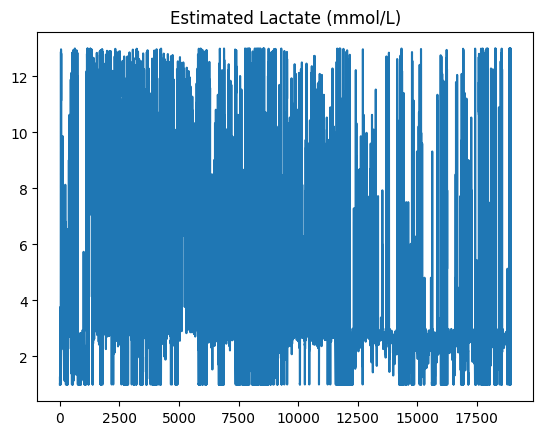

In [10]:
def estimate_lactate(power, ftp):
    lactate_rest = 1.0
    lactate_peak = 12.0
    if power <= ftp:
        return lactate_rest + (power / ftp) * 2
    else:
        return lactate_rest + 2 + (lactate_peak - 2) * (1 - np.exp(-(power - ftp) / (0.1 * ftp)))
df['lactate_est'] = df['power'].apply(lambda p: estimate_lactate(p, ftp))
df['lactate_est'].plot(title='Estimated Lactate (mmol/L)')
plt.show()